# 0. Получение данных

In [1]:
import matplotlib
% matplotlib inline

matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.style.use('seaborn-notebook')
matplotlib.rcParams['figure.figsize'] = (7, 3)

import pandas as pd

df = pd.read_csv('выгрузки.csv', sep=';')

'Данных в выгрузке {}'.format(len(df))

'Данных в выгрузке 1200'

Посмотрим на структуру данных

In [2]:
df.head(5)

,ID,CLASS,X01,X02,X03,X04,X05,X06,X07,X08,...,X54,X55,X56,X57,X58,X59,X60,X61,DATETIME_OPEN,DATETIME_CHECK
0,1,2,0,0,2,2,0,0,0,0,...,5539.0,2,0,NaN,NaN,NaN,NaN,NaN,2016-07-20 00:00:00,2016-08-01 20:31:52
1,2,2,0,0,0,0,0,0,0,0,...,4365.0,0,0,NaN,NaN,NaN,NaN,NaN,2016-07-29 00:00:00,2016-08-01 15:00:29
2,3,2,2,1,28,8,4,5,2,4,...,14607.0,24,1,NaN,NaN,NaN,NaN,-747.0,2016-07-18 00:00:00,2016-08-01 13:23:41
3,4,2,0,0,2,2,0,0,0,0,...,14374.0,2,0,-40.0,-40.0,NaN,NaN,NaN,2016-07-13 00:00:00,2016-08-01 10:22:52
4,5,2,0,0,10,6,0,0,0,0,...,19575.0,8,3,NaN,NaN,NaN,NaN,NaN,2016-07-14 00:00:00,2016-08-01 09:45:53


Посмотрим на количество записей определенного класса

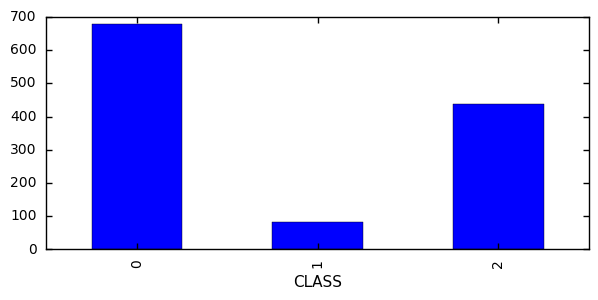

In [3]:
df.groupby('CLASS').size().plot(kind='bar')

## 0.1 Анализ признаков

### 0.1.1. Анализ признаков, зависимых от времени

Как можно заметить, признаки даты сравнимы, однако представлены в виде строк. Переведем их в unix формат для того, чтобы классификаторы имели возможность работы с ними

In [4]:
import time
from datetime import datetime

def date_to_unix(date):
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    return time.mktime(date.timetuple())

df['DATETIME_OPEN'] = df['DATETIME_OPEN'].apply(lambda x: date_to_unix(x))
df['DATETIME_CHECK'] = df['DATETIME_CHECK'].apply(lambda x: date_to_unix(x))

Проверим плотность распределения получившихся признаков

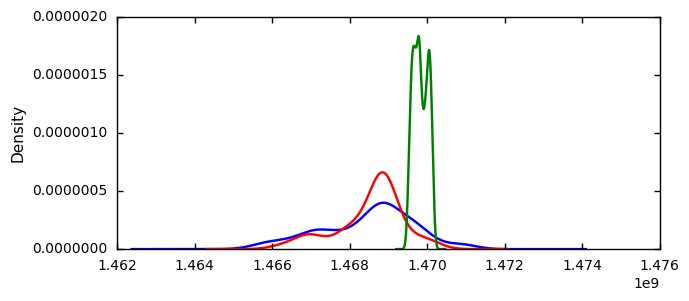

In [5]:
ax = df[df.CLASS == 2].DATETIME_CHECK.plot(kind='kde', color='b')
ay = df[df.CLASS == 1].DATETIME_CHECK.plot(kind='kde', color='r', ax=ax)
df[df.CLASS == 0].DATETIME_CHECK.plot(kind='kde', color='g', ax=ay)

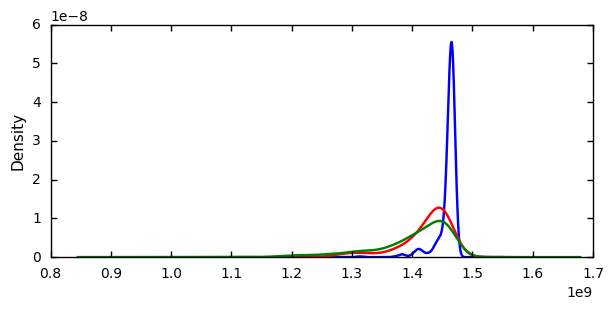

In [6]:
ax = df[df.CLASS == 2].DATETIME_OPEN.plot(kind='kde', color='b')
ay = df[df.CLASS == 1].DATETIME_OPEN.plot(kind='kde', color='r', ax=ax)
df[df.CLASS == 0].DATETIME_OPEN.plot(kind='kde', color='g', ax=ay)

Также заметим, что поле ID является идентификатором, однако глядя на плотность его распределения нельзя с уверенностью сказать, что оно не информативно

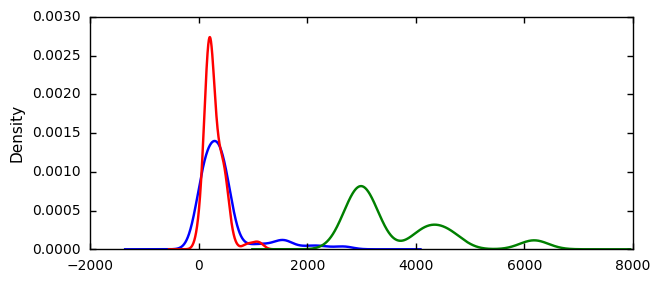

In [7]:
ax = df[df.CLASS == 2].ID.plot(kind='kde', color='b')
ay = df[df.CLASS == 1].ID.plot(kind='kde', color='r', ax=ax)
df[df.CLASS == 0].ID.plot(kind='kde', color='g', ax=ay)

Несмотря на то, что признаки выглядят информативными, их не стоит использовать при обучении, поскольку они будут информативны лишь на этом наборе. При добавлении новых данных зависимости изменятся (так как все 3 признака зависят от времени)

### 0.1.2. Анализ признаков, содержащих отсутствующие данные

Посмотрим на количество записей, содержащих NaN в определенном поле

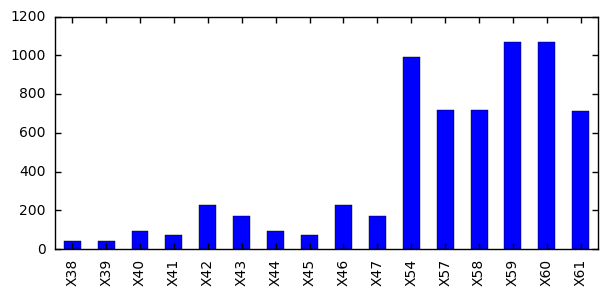

In [8]:
NaNs = df.isnull().sum()
NaNs[NaNs > 0].plot(kind='bar')

Как можно заметить, признаки `X54, X57, X58, X59, X60 и X61` имеют более 50% отсутствующих данных, поэтому нужно более внимательно определить их структуру.  
Остальные же признаки имеют незначительное количество незаполненных данных, в дальнейшем можно заполнить их медианой или средним.

Посмотрим на количество записей определенного класса, содержащихся в этих 6 признаках

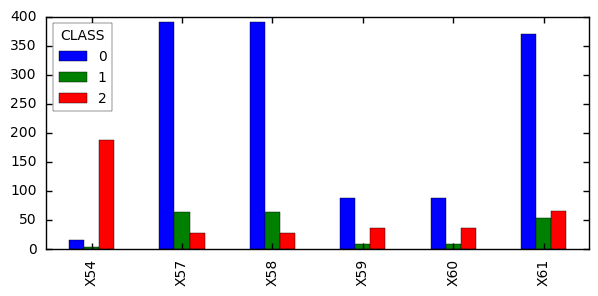

In [9]:
new_dict = {}

for element in NaNs[NaNs > len(df) // 2].index:
    new_dict[element] = df[df[element].notnull()].groupby('CLASS').size()
    
pd.DataFrame(new_dict).transpose().plot(kind='bar')

Заметим, что признаки X54, X57, X58 и X61 имеют достаточно большое количество записей определенного класса.  
Однако из-за того, что записей мало, предполагается их использование в качестве отдельного классификатора в ансамбле.  
Признаки X59 и X60, исходя из графика, малоинформативны, их можно отбросить и не учитывать далее, однако лучше проанализировать их значимость, чем мы займемся в дальнейшем.

# 1. Подготовка таблицы. Перемешивание признаков
********************************************
Переведите категориальные признаки, если такие будут, в бинарные. Перемешайте выборку. 
********************************************

In [10]:
df = df[df.CLASS != 1]

Нет категориальных признаков, поэтому просто производим перемешивание.   
http://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html

In [11]:
from sklearn.utils import shuffle

shuffled_df = shuffle(df[list(df.columns)[1:-2]])
shuffled_df.head(5)

,CLASS,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61
392,2,16,1,9,5,0,0,0,0,4,...,0,0,NaN,6,2,NaN,NaN,NaN,NaN,NaN
684,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN
372,2,118,1,161,36,16,22,17,10,35,...,0,0,NaN,62,35,-50.0,-50.0,NaN,NaN,-147.0
266,2,47,2,27,0,1,7,7,9,3,...,0,0,NaN,16,3,NaN,NaN,NaN,NaN,-51.0
961,0,78,3,22,0,4,2,4,3,4,...,0,0,NaN,9,4,-168.0,-100.0,NaN,NaN,-600.0


# 2. Выбор значимых признаков
********************************************
Определите наиболее характерные и наименее характерные признаки. Определите наиболее и наименее характерные пары признаков. Из множества наименее характерных признаков удалите две тройки наименее характерных признаков.
********************************************

## 2.1 Приготовим таблицу, заполнив недостающие данные

Для начала заполним недостающие участки медианой для сохранения распределения, поскольку без этого невозможно будет определить значимость фич.  
Как было показано ранее, признаки X54, X57, X58 и X61 не будут заполнены, поскольку они не будут использованы в обучающей модели.

In [12]:
NaNs = shuffled_df.isnull().sum()
columns_to_imput = list(NaNs[(NaNs < len(shuffled_df) // 2) & (NaNs > 0)].index)
print(columns_to_imput)

for column in columns_to_imput:
    shuffled_df[column] = shuffled_df[[column]].fillna(shuffled_df[[column]].median(numeric_only=True))
    
shuffled_df.head(5)

['X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47']


,CLASS,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61
392,2,16,1,9,5,0,0,0,0,4,...,0,0,NaN,6,2,NaN,NaN,NaN,NaN,NaN
684,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN
372,2,118,1,161,36,16,22,17,10,35,...,0,0,NaN,62,35,-50.0,-50.0,NaN,NaN,-147.0
266,2,47,2,27,0,1,7,7,9,3,...,0,0,NaN,16,3,NaN,NaN,NaN,NaN,-51.0
961,0,78,3,22,0,4,2,4,3,4,...,0,0,NaN,9,4,-168.0,-100.0,NaN,NaN,-600.0


Теперь сохраним признаки X54, X57, X58, X61 для дальнейшего использования в ансамбле.  
А затем удалим их, а также X59, X60, чтобы построить нормальный классификатор.

Как оценить значимость фич на малом объеме данных (X59, X60) ???

In [13]:
ensible_df = shuffled_df[['CLASS', 'X54', 'X57', 'X58', 'X61']]
shuffled_df.drop(['X54', 'X57', 'X58', 'X59', 'X60', 'X61'], axis=1, inplace=True)
shuffled_df.head(5)

,CLASS,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X46,X47,X48,X49,X50,X51,X52,X53,X55,X56
392,2,16,1,9,5,0,0,0,0,4,...,26.0,526.0,2,0,0,2,0,0,6,2
684,0,0,0,0,0,0,0,0,0,0,...,549.0,10403.5,4,0,0,3,0,0,0,0
372,2,118,1,161,36,16,22,17,10,35,...,103.0,2425.0,5,0,0,5,0,0,62,35
266,2,47,2,27,0,1,7,7,9,3,...,726.0,6498.0,2,0,0,2,0,0,16,3
961,0,78,3,22,0,4,2,4,3,4,...,76649.0,33666.0,3,0,0,3,0,0,9,4


## 2.2 Получим наиболее информативные признаки

Для начала разобъем наши данные на непосредственно признаки и принадлежность этих признаков к классу.

In [14]:
columns = list(shuffled_df.columns)
columns.remove('CLASS')

X = shuffled_df[columns]
Y = shuffled_df.CLASS

### 2.2.1. Используем SelectKBest

Выведем 5 наиболее иформативных признаков с помощью функции `SelectKBest`.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [15]:
from sklearn.feature_selection import SelectKBest

kbest = SelectKBest(k=5).fit(X, Y)
list(map(lambda x: X.columns[x], kbest.get_support(indices=True)))

['X02', 'X04', 'X15', 'X24', 'X49']

### 2.2.2. Используем ExtraTreesClassifier

Теперь с помощью `ExtraTreesClassifier` получим информативность всех фич  
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

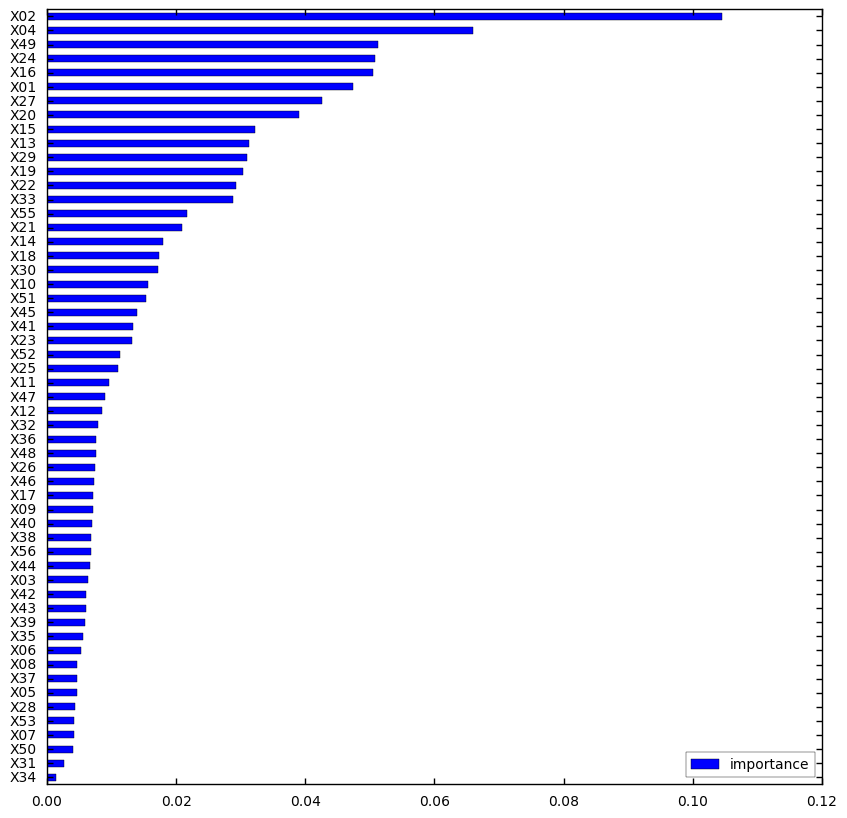

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

matplotlib.rcParams['figure.figsize'] = (10, 10)

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X=X, y=Y)
df_features = pd.DataFrame.from_dict({a: b for a, b in zip(X.columns, forest.feature_importances_)}, orient='index')
df_features.columns = ['importance']
df_features.sort_values(by='importance').plot(kind='barh')

### 2.2.2. Используем RandomForestClassifier

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

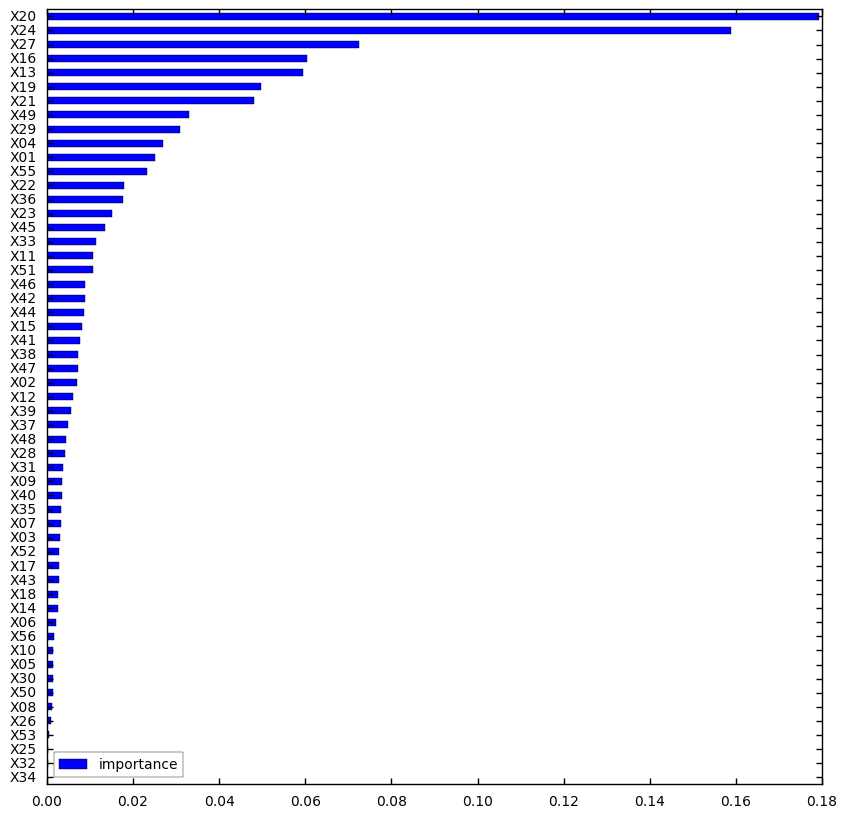

In [17]:
from sklearn.ensemble import RandomForestClassifier

matplotlib.rcParams['figure.figsize'] = (10, 10)

forest = RandomForestClassifier()

forest.fit(X=X, y=Y)
df_features = pd.DataFrame.from_dict({a: b for a, b in zip(X.columns, forest.feature_importances_)}, orient='index')
df_features.columns = ['importance']
df_features.sort_values(by='importance').plot(kind='barh')

### 2.2.3. Используем DecisionTreeClassifier

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

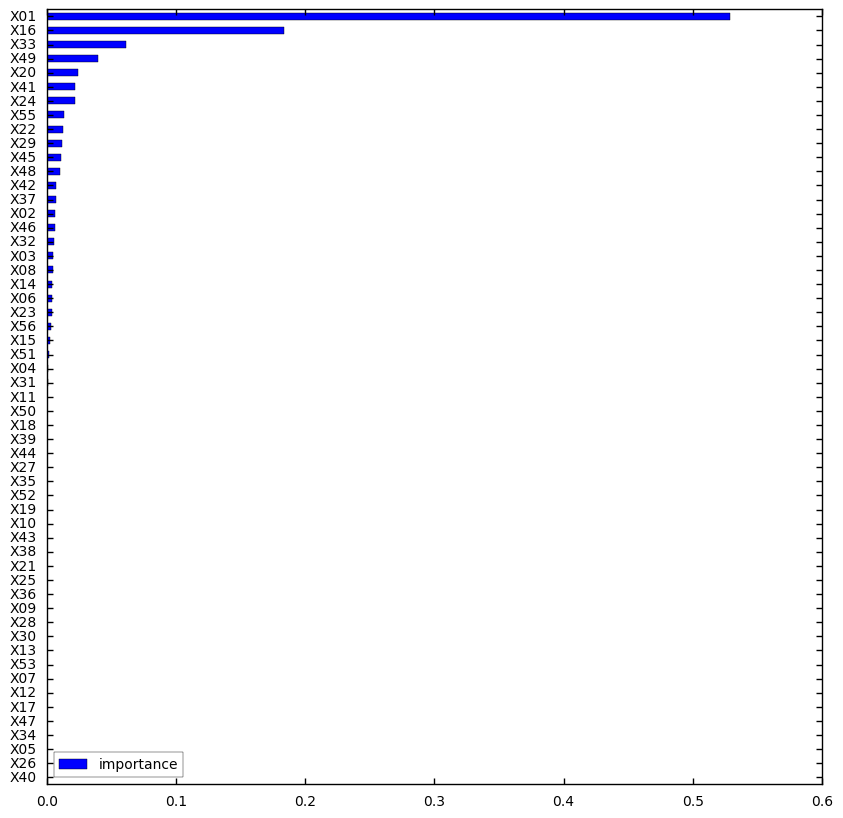

In [18]:
from sklearn.tree import DecisionTreeClassifier

matplotlib.rcParams['figure.figsize'] = (10, 10)

forest = DecisionTreeClassifier()

forest.fit(X=X, y=Y)
df_features = pd.DataFrame.from_dict({a: b for a, b in zip(X.columns, forest.feature_importances_)}, orient='index')
df_features.columns = ['importance']
df_features.sort_values(by='importance').plot(kind='barh')

## 2.3. Определим наиболее и наименее характерные пары признаков

Для этого получим все пары признаков, а затем при помощи кросс-валидации на RandomForest получим оценку эффективности этой пары признаков

In [89]:
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


result = []

for a, b in combinations(X.columns, 2):
    clf = RandomForestClassifier(max_depth=5, n_estimators=10)
    result.append((a, b, cross_val_score(clf, X[[a, b]], Y, cv=5).mean()))

In [91]:
import operator

print('Max pair is: {}'.format(max(result, key=operator.itemgetter(2))))
print('Min pair is: {}'.format(min(result, key=operator.itemgetter(2))))

Max pair is: ('X04', 'X15', 0.92202853478077684)
Min pair is: ('X25', 'X26', 0.59592495281957159)


# 3. Использование PCA
**********************************************
Попробуйте так же удалить наименее характерные признаки с помощью PCA
**********************************************

Для начала запустим PCA без указания количества фич

In [19]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
print(pca.fit(X))

pca.explained_variance_

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


array([  1.47210214e+13,   8.21827091e+11,   4.87951206e+11,
         2.89556561e+11,   2.41660517e+11,   1.18319481e+11,
         3.06314365e+10,   2.44882671e+10,   1.33073843e+10,
         1.07606987e+10,   1.35377743e+09,   7.96015371e+08,
         4.63913313e+07,   4.34111586e+05,   9.26415013e+04,
         3.26051614e+04,   2.92714105e+03,   1.57344778e+03,
         1.10691327e+03,   5.90443609e+02,   3.99373173e+02,
         3.66101302e+02,   2.29258444e+02,   1.93953405e+02,
         1.53443021e+02,   1.27852137e+02,   1.15557802e+02,
         9.77336648e+01,   8.71789870e+01,   6.97416585e+01,
         6.30302154e+01,   4.33522039e+01,   3.77830866e+01,
         3.33881186e+01,   2.49172778e+01,   1.39677806e+01,
         1.21153106e+01,   9.02773138e+00,   7.71000172e+00,
         7.26981238e+00,   6.08699254e+00,   4.82858660e+00,
         4.05773859e+00,   3.37012198e+00,   2.59956975e+00,
         1.71511061e+00,   1.29293172e+00,   1.17254104e+00,
         8.44418082e-01,

Как можно заметить, дисперсия значений признаков колеблется от 1e13 до 1e-19. Для примера оставим первые 10 фич и применим преобразование к данным:

In [20]:
pca.set_params(n_components=20)
data = pca.fit_transform(X)
data

array([[ -3.74301984e+05,   9.57137537e+04,  -1.81399852e+05, ...,
         -6.20491720e+00,   9.81069765e+00,   5.92314872e+00],
       [ -3.72955768e+05,  -2.10945858e+05,  -3.30781277e+04, ...,
         -1.54079866e+01,   9.80316673e+00,   4.95087711e+00],
       [ -3.74196726e+05,  -4.09330034e+05,   8.17171805e+04, ...,
          7.76831191e+01,   2.04245864e+01,   6.31323236e+01],
       ..., 
       [ -2.93739625e+05,   2.75171690e+06,  -1.74274800e+06, ...,
         -1.13979103e+01,   8.26814188e+00,   1.03432645e+01],
       [ -3.32302714e+05,   1.19741382e+06,  -6.21120991e+05, ...,
          9.87785896e+00,   2.34116078e+01,  -2.98324534e+01],
       [ -3.68459619e+05,  -2.13287085e+05,   1.18643070e+04, ...,
          4.79884867e+00,   1.72819985e+01,  -1.45006434e+01]])

Заметим, что вид данных изменился. 

In [21]:
data.shape

(1116, 20)

# 4. Кросс валидация
**********************************************
Кросс-валидацией из множества стандартных алгоритмов найдите наилучший.
**********************************************

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score


names = [
    "Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
]

for name, clf in zip(names, classifiers):
    print('{} - {}'.format(name, cross_val_score(clf, X, Y, cv=5).mean()))

Nearest Neighbors - 0.8458546150250186
RBF SVM - 0.6120124328364238
Gaussian Process - 0.6182865280398913
Decision Tree - 0.9435372552244751
Random Forest - 0.920295086887015
Neural Net - 0.7311755862204293
AdaBoost - 0.9731058933693463
Naive Bayes - 0.696242158237674


# 5. Построение и оценка классификаторов
*****************************************************
Разделите признаки на три части: «совсем характерные», «средне характерные» и «наименее характерные».  
Постройте SVN на «совсем характерных» оцените его полноту и точность, f1 меру, постройте ROC кривую, оцените отношение полнота/точность, auc.  
Постройте RandomForest и sklearn.dummy.DummyClassifier алгоритм, анологично рассчитайте эти характеристики для них.
*****************************************************

Для начала разобьем выборку на обучающую и проверочную

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

Разделение признаков условно, для этого попробуем взять первые 10 признаков, имеющие наибольшую информативность по версии ExtraTreesClassifier

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X=X, y=Y)
df_features = pd.DataFrame.from_dict({a: b for a, b in zip(X.columns, forest.feature_importances_)}, orient='index')
df_features.columns = ['importance']
main_features = list(df_features.sort_values(by='importance', ascending=False).head(3).index)

## 5.1. Построим классификатор SVC

In [25]:
from sklearn.svm import SVC

clf = SVC(probability=True, kernel='rbf', gamma=.1)
print(clf)
clf.fit(X_train[main_features], y_train)
y_result = clf.predict(X_test[main_features])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [26]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test[main_features])])

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.93      0.96      0.95       165
          2       0.94      0.90      0.92       114

avg / total       0.94      0.94      0.94       279



Gini coef is 0.92


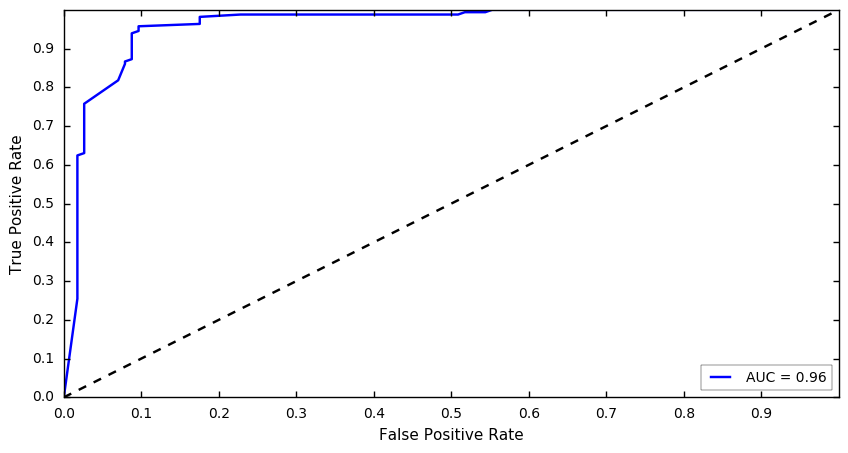

In [28]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

## 5.2. Построим классификатор RandomForestClassifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
print(clf)

clf.fit(X_train[main_features], y_train)
y_result = clf.predict(X_test[main_features])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [30]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test[main_features])])

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       165
          2       0.96      0.90      0.93       114

avg / total       0.95      0.95      0.95       279



Gini coef is 0.92


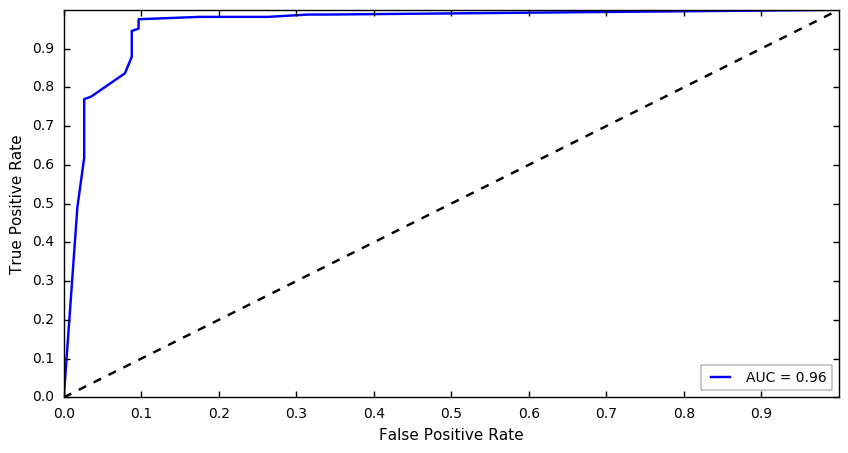

In [32]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

## 5.3. Построим классификатор DummyClassifier

In [33]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='stratified')
print(clf)

clf.fit(X_train[main_features], y_train)
y_result = clf.predict(X_test[main_features])
y_result

DummyClassifier(constant=None, random_state=None, strategy='stratified')


array([0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0,
       2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2])

In [34]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])
y_result_proba

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0])

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.59      0.63      0.61       165
          2       0.41      0.38      0.39       114

avg / total       0.52      0.53      0.52       279



Gini coef is 0.07


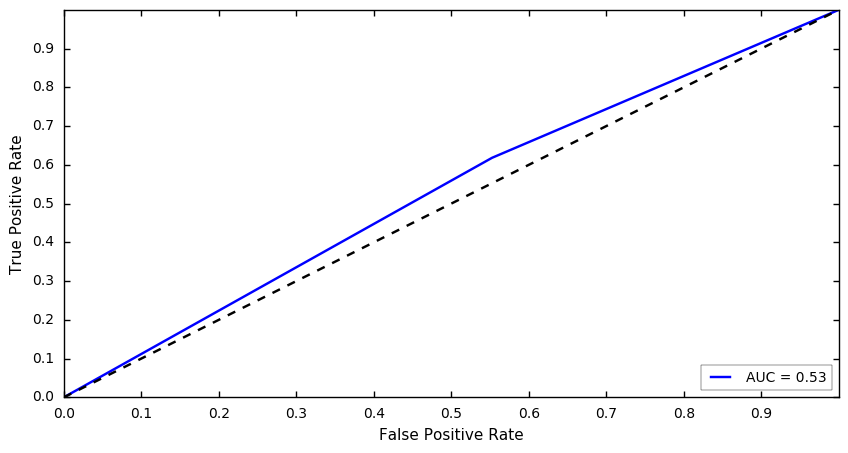

In [36]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

# 6. Построение классификаторов на всем наборе признаков
*******************************************************************************************
Постройке различные классификаторы на всем множестве признаков; рассчитайте их полноту, точность, ROC кривую, auc.
*******************************************************************************************

## 6.1. RandomForestClassifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
print(clf)

clf.fit(X_train, y_train)
y_result = clf.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [38]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       165
          2       0.97      0.96      0.96       114

avg / total       0.97      0.97      0.97       279



Gini coef is 1.00


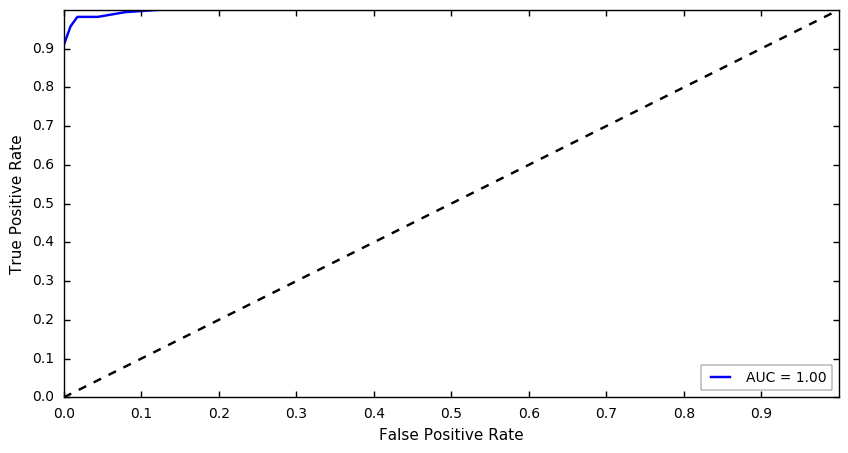

In [40]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

## 6.2. KNeighborsClassifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(5)
print(clf)

clf.fit(X_train, y_train)
y_result = clf.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


In [42]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.89      0.86      0.88       165
          2       0.81      0.85      0.83       114

avg / total       0.86      0.86      0.86       279



Gini coef is 0.83


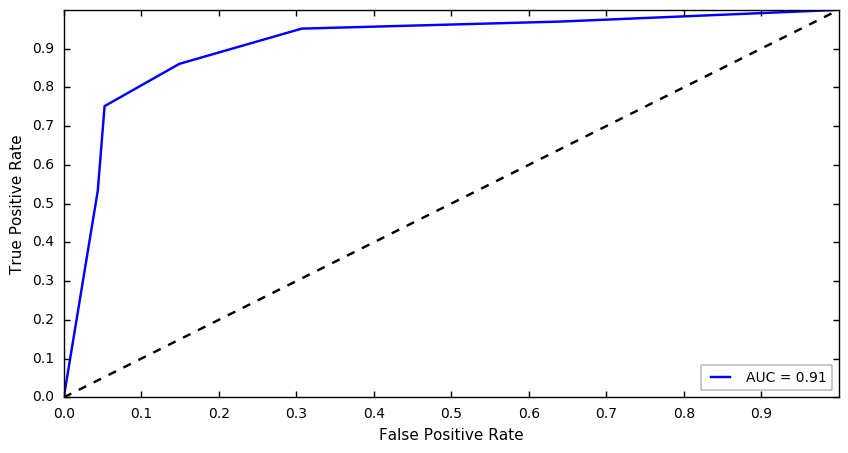

In [44]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

## 6.3. DecisionTreeClassifier

In [45]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5)
print(clf)

clf.fit(X_train, y_train)
y_result = clf.predict(X_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [46]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.96      0.93      0.95       165
          2       0.91      0.95      0.93       114

avg / total       0.94      0.94      0.94       279



Gini coef is 0.89


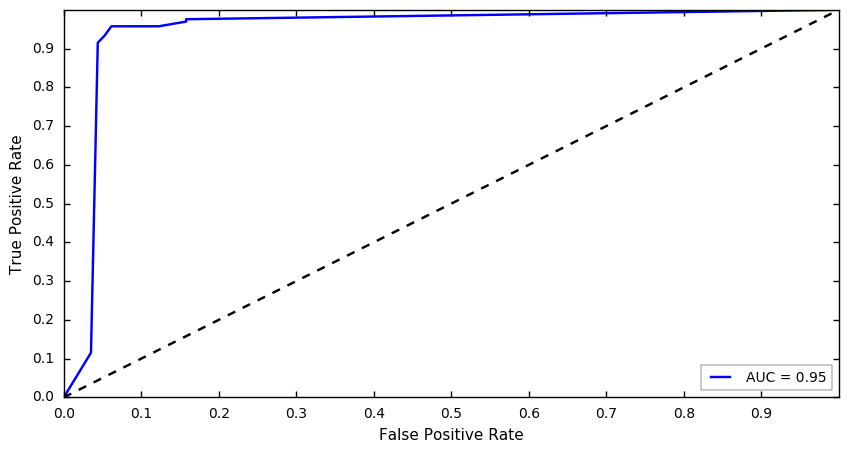

In [48]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

## 6.4.  AdaBoostClassifier

In [49]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
print(clf)

clf.fit(X_train, y_train)
y_result = clf.predict(X_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


In [50]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       165
          2       0.98      0.99      0.99       114

avg / total       0.99      0.99      0.99       279



Gini coef is 1.00


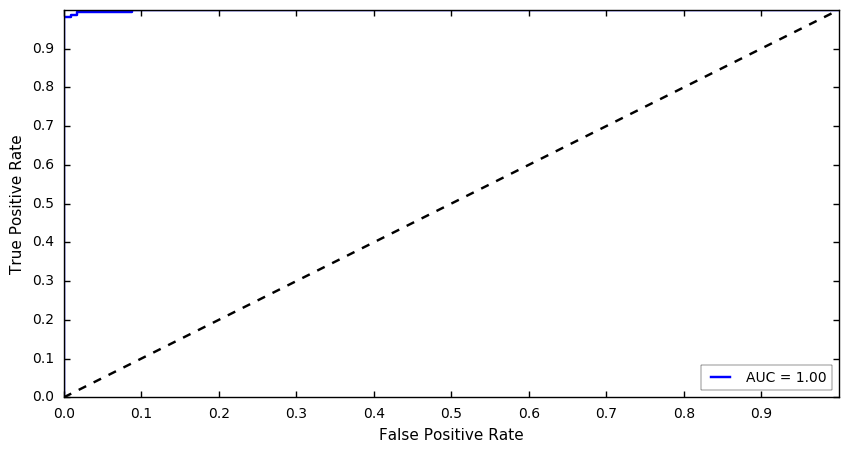

In [52]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

## 6.5. GaussianNB

In [53]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
print(clf)

clf.fit(X_train, y_train)
y_result = clf.predict(X_test)

GaussianNB(priors=None)


In [54]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.97      0.46      0.63       165
          2       0.56      0.98      0.71       114

avg / total       0.80      0.67      0.66       279



Gini coef is 0.88


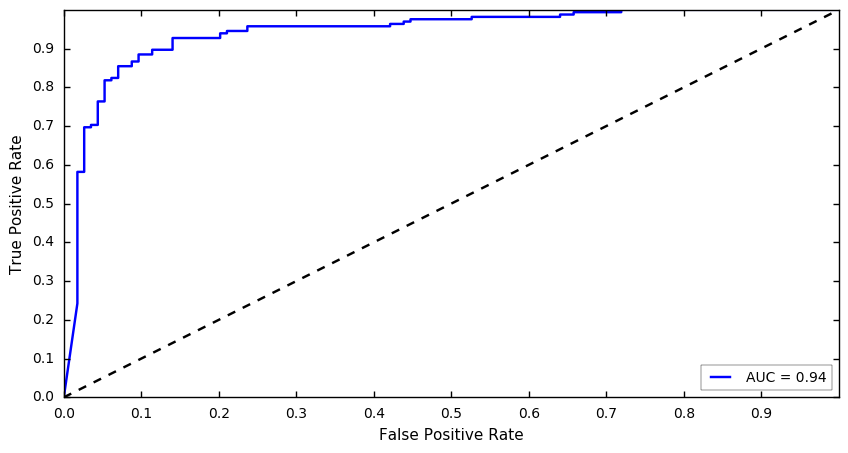

In [56]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

## 6.6. LogisticRegression

In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
print(clf)

clf.fit(X_train, y_train)
y_result = clf.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [58]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])

In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.94      0.93      0.94       165
          2       0.90      0.92      0.91       114

avg / total       0.93      0.92      0.92       279



Gini coef is 0.95


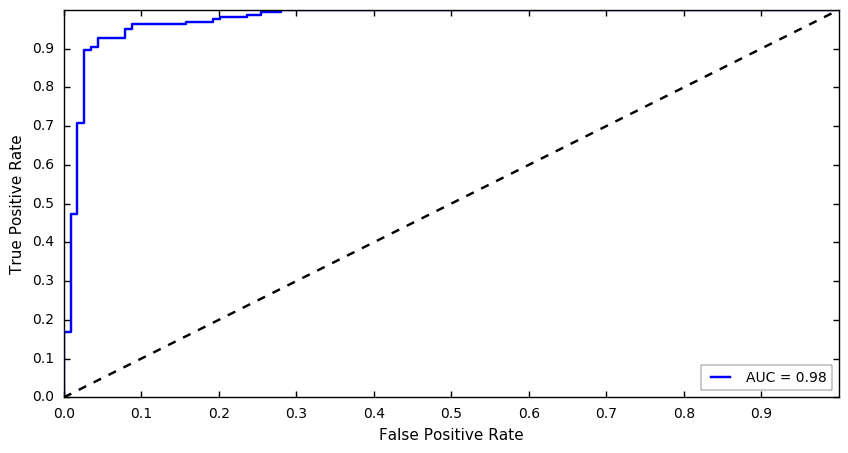

In [60]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

# 7. Создание ансамбля
************************************************************************
Попробуйте построить ансамбль с лучшим auc, чем для классификаторов из п.5
************************************************************************

Особого смысла в этом нет, поскольку резльтат классификатора адаптивного бустинга близок к идеальному. Поэтому немного изменим задание - попробуем построить классификатор из менее удачных классификаторов (для данного набора), и попытаемся построить ансамбль на них.  
В качестве классификаторов возьмем `LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier`.  
Ансамбль будет выполнен в виде функции голосования с одинаковыми весами для каждого из классификатора.

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier


clf1 = LogisticRegression(random_state=0)
clf2 = KNeighborsClassifier()
clf3 = DecisionTreeClassifier(random_state=0)

eclf = VotingClassifier(estimators=[('lr', clf1), ('kn', clf2), ('dt', clf3)], voting='soft')

Попробуем еще одну вещь - максимизируем результат ансамбля при помощи перебора параметров. Для этого используем `GridSearchCV`, передав в него параметры для перебора.

In [62]:
params = {
    'lr__C': [1.0, 10.0, 100.0],
    'kn__n_neighbors': [1, 5, 10],
    'dt__max_depth': [5, 10, None]
}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5, verbose=1)
grid = grid.fit(X_train, y_train)

clf = grid.best_estimator_
y_result = clf.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   26.7s finished


Получим набор параметров, дающий наивысший скор

In [63]:
grid.best_params_

{'dt__max_depth': 5, 'kn__n_neighbors': 10, 'lr__C': 10.0}

In [64]:
import numpy as np

y_result_proba = np.array([a[0] for a in clf.predict_proba(X_test)])

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_result, labels=[0, 2]))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       165
          2       0.98      0.90      0.94       114

avg / total       0.95      0.95      0.95       279



Gini coef is 0.98


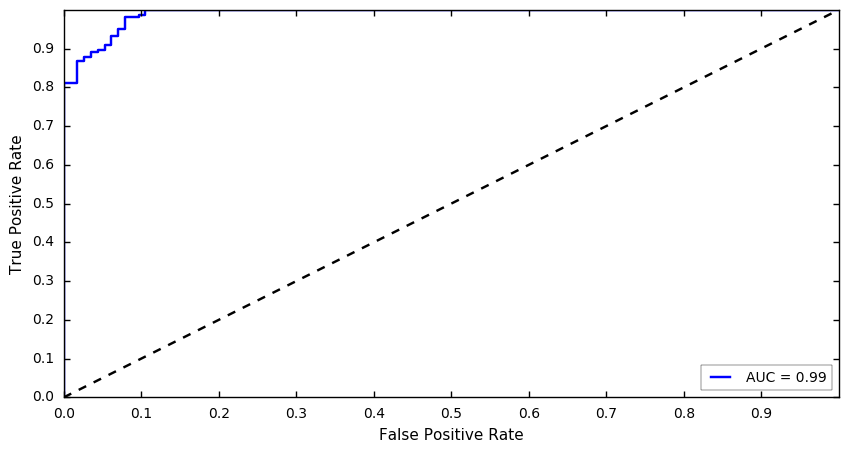

In [66]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

fpr, tpr, thresholds = roc_curve(y_test, y_result_proba, pos_label=0)

roc_auc = auc(fpr, tpr)
print('Gini coef is {:.2f}'.format(2 * roc_auc - 1))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks(np.arange(0, 1.0, 0.1))
plt.show()

Как можно заметить, получившийся ансамбль дает лучшую ROC-кривую, нежели классификаторы, входящие в его состав по-отдельности

# 8. Оценка с помощью кросс-валидации
*********************************************************
Кросс валидацией оцените классификатор из п.6 с классификаторами из п.5
*********************************************************

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

clf1 = LogisticRegression(random_state=0, C=100.0)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = DecisionTreeClassifier(random_state=0, max_depth=5)

eclf = VotingClassifier(estimators=[('lr', clf1), ('kn', clf2), ('dt', clf3)], voting='soft')

cross_val_score(eclf, X, Y, cv=cv).mean()

0.9334821428571427

In [68]:
clf = RandomForestClassifier()

cross_val_score(clf, X, Y, cv=cv).mean()

0.96026785714285734

# 9. Сохранение результатов
**************************************************
С помощью pickle сохраните кортеж содержащий классификатор, полноту и точность, краткое описание в вольной форме. Сохраните в два файла: для разных версий Python (2-я и 3-я). Для проверки загрузите один из сохраненных файлов.
**************************************************

In [81]:
import pickle

data = (
    eclf,
    0.95,
    0.95,
    'Voting Ensable with LogisticRegression, KNeighbors and DecisionTree'
)

# Сохраним при помощи протокола  2 для обратной совместимости
with open('data.pkl', 'wb') as pickle_file:
    pickle.dump(data, pickle_file, 2)

In [82]:
with open('data.pkl', 'rb') as pickle_file:
    result = pickle.load(pickle_file)
    
result

(VotingClassifier(estimators=[('lr', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)), ('kn', KNeighbo...split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'))],
          n_jobs=1, voting='soft', weights=None),
 0.95,
 0.95,
 'Voting Ensable with LogisticRegression, KNeighbors and DecisionTree')